### How to Model the Project:

- **Initial State** : The initial state is an \( $n \times n$ \) matrix provided as input to the algorithm, where each element is either 0 (light off) or 1 (light on).

- **Goal State** : The goal state is achieved when all the lights in the matrix are turned off, meaning every element in the \( $n \times n$ \) matrix is 0.

- **Action** : In each state, an action consists of toggling one key (cell) in the matrix. This action changes the value of the selected cell and its four adjacent neighbors (above, below, left, and right). Each toggle switches 1 to 0 and 0 to 1. Performing this action leads to a new state.

- **Transition Model** : The transition model describes how the system moves from one state to another. After each action (toggle), the value of the selected cell and its four neighboring cells are flipped, creating a new configuration of the matrix.


In [1]:
import random
import heapq
from dataclasses import dataclass, field
from typing import List, Tuple, Callable, Any, Set
import numpy as np
from time import time
from tabulate import tabulate
import threading
import collections
from math import ceil
from enum import Enum
from functools import partial
from copy import deepcopy
from collections import deque

In [41]:
class LightsOutPuzzle:
    def __init__(self, board: List[List[int]]):
        self.board = np.array(board, dtype=np.uint8)
        self.size = len(board)

    def toggle(self, x, y):
        for dx, dy in [(0, 0), (1, 0), (-1, 0), (0, 1), (0, -1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < self.size and 0 <= ny < self.size:
                self.board[nx, ny] ^= 1

    def is_solved(self):
        return np.all(self.board == 0)

    def get_moves(self):
        return [(x, y) for x in range(self.size) for y in range(self.size)]

    def __str__(self):
        return '\n'.join(' '.join(str(cell) for cell in row) for row in self.board)

    def get_rotations(self):
        rotations = [np.rot90(self.board, k).copy() for k in range(4)]
        return rotations

In [42]:
def create_random_board(size: int,  seed: int, num_toggles: int = None):
    random.seed(time() if seed is None else seed)

    board = [[0 for _ in range(size)] for _ in range(size)]
    puzzle = LightsOutPuzzle(board)

    if num_toggles is None:
        num_toggles = random.randint(1, size * size)

    for _ in range(num_toggles):
        x = random.randint(0, size - 1)
        y = random.randint(0, size - 1)
        puzzle = puzzle.toggle(x, y)

    return puzzle.board

In [43]:
def show_solution(
    puzzle: LightsOutPuzzle,
    solution: List[Tuple[int, int]],
    algorithm_name: str,
    nodes_visited: int,
    show_steps: bool = False,
):
    print(f"\nSolving with {algorithm_name}:")
    if solution is None:
        print("No solution found.")
        return
    print(f"Solution: {solution}")
    print(f"Nodes visited: {nodes_visited}")
    if show_steps:
        print("\nSolution steps:")
        for i, move in enumerate(solution):
            print(f"\nStep {i+1}: Toggle position {move}")
            puzzle.toggle(*move)
            print(puzzle)
        print(
            "\nFinal state (solved):"
            if puzzle.is_solved()
            else "\nFinal state (not solved):"
        )
        print(puzzle)

In [44]:
tests = [
    create_random_board(3, 42),
    create_random_board(3, 41),
    create_random_board(3, 42, 5),
    create_random_board(4, 42),
    create_random_board(4, 41),
    create_random_board(4, 42, 5),
    create_random_board(5, 42),
    create_random_board(5, 41),
    create_random_board(5, 42, 5),
]

### defind node for model the problem

we defind a node fo our algorithm to for model it

In [45]:
class Node:
    def __init__(self, state, parent=None, action=None, toggled_points=None, moves=None):
        self.state = state
        self.parent = parent
        self.action = action
        self.g = 0  # Cost from start node to this node
        self.h = 0  # Heuristic estimate of cost from this node to goal
        self.f = 0  # Total estimated cost (g + h)
        self.moves = moves if moves is not None else set()  # Use a set to keep track of moves

    def __lt__(self, other):
        return (self.f, self.g) < (other.f, other.g)

### Breadth-First Search (BFS)

Breadth-First Search (BFS) explores the search space level by level, expanding all nodes at a given depth before moving to nodes at the next depth level. BFS is typically implemented using a queue data structure, where nodes are added to the queue as they are discovered and removed for expansion. This ensures that nodes are processed in the order they are encountered, level by level.

BFS guarantees finding the optimal solution in the context of uniform-cost search, where each action has the same cost. This makes BFS an optimal algorithm for unweighted search problems. However, the time complexity can grow significantly since it explores all possible states, making it computationally expensive for large state spaces.

The time complexity of BFS is $O(b^d)$, where $b$ is the branching factor and $d$ is the depth of the shallowest solution. The space complexity is also $O(b^d)$, as BFS stores all the nodes at the current level before moving on to the next.


### BFS soloution

In [46]:
from collections import deque
from copy import deepcopy
import numpy as np

def state_to_tuple(board):
    return tuple(map(tuple, board))

def bfs_solve(puzzle: LightsOutPuzzle) -> Tuple[List[Tuple[int, int]], int]:
    if puzzle.size >= 5:
        return [], 0
    num_explored = 0
    start = Node(state=puzzle, parent=None, action=None, moves=set())
    frontier = deque([start])
    explored = set()

    while frontier:
        node = frontier.popleft()
        state_tuple = state_to_tuple(node.state.board)

        if state_tuple in explored:
            continue

        explored.add(state_tuple)
        num_explored += 1

        if node.state.is_solved():
            actions = []
            while node.parent is not None:
                actions.append(node.action)
                node = node.parent
            actions.reverse()
            return actions, num_explored

        for move in node.state.get_moves():
            if move in node.moves:
                continue
            new_state = deepcopy(node.state)
            new_state.toggle(move[0], move[1])
            new_state_tuple = state_to_tuple(new_state.board)

            if new_state_tuple not in explored:
                child = Node(state=new_state, parent=node, action=move, moves=node.moves | {move})
                frontier.append(child)

    raise Exception("No solution")



### Iterative Deepening Search (IDS)

Iterative Deepening Search (IDS) combines the space efficiency of Depth-First Search (DFS) with the completeness of Breadth-First Search (BFS). IDS works by repeatedly applying Depth-Limited Search (DLS) with increasing depth limits. In each iteration, the algorithm explores the search tree up to a specific depth limit, and if no solution is found, it increases the depth limit and restarts the search from the root.

This approach ensures that the shallowest solution is found, just like BFS, but without the high memory usage since IDS only stores a single path in memory, similar to DFS. Despite re-exploring nodes in each iteration, the overall time complexity remains the same as BFS, since most of the effort is concentrated at the deepest levels of the search.

IDS is implemented recursively or using a stack, similar to DFS, but it introduces an outer loop to gradually increase the depth limit. This algorithm is especially useful in large or infinite search spaces where memory usage is a concern.

The time complexity of IDS is $O(b^d)$, where $b$ is the branching factor and $d$ is the depth of the shallowest solution. The space complexity is $O(b \cdot d)$, as IDS only needs to store the current path and the depth limit for each iteration.


### Depth-limited search function for IDS algorithm

In [47]:
def dls_solve(node: Node, limit: int, explored: set, num_explored: int) -> Tuple[List[Tuple[int, int]], int]:
    
    if node.state.is_solved():
        actions = []
        while node.parent is not None:
            actions.append(node.action)
            node = node.parent
        actions.reverse()
        return actions, num_explored

    if limit == 0:
        return None, num_explored

    explored.add(node.state)

    neighbors = []
    moves = node.state.get_moves()
    for move in moves:
        neighbors.append((move, node.state.toggle(move[0],move[1])))

    for action, state in neighbors:
        if state not in explored:
            child = Node(state=state, parent=node, action=action)
            result, num_explored = dls_solve(child, limit - 1, explored, num_explored + 1)
            if result is not None:
                return result, num_explored

    return None, num_explored


### IDS soloution

In [48]:
def ids_solve(puzzle: LightsOutPuzzle) -> Tuple[List[Tuple[int, int]], int]:
    
    #this is becuse we dont want to test this algorithm for size more than 5
    if puzzle.size >= 5:
        return [], 0
    
    num_explored = 0
    
    # Keep trying with increasing depth limits
    for depth in range(1000):
        explored = set()
        start = Node(state=puzzle, parent=None, action=None)
        result, num_explored = dls_solve(start, depth, explored, num_explored)
        if result is not None:
            return result, num_explored

    raise Exception("no solution")

### A* Search Algorithm

A* (A-Star) Search is an informed search algorithm that finds the optimal solution by combining the benefits of both uniform-cost search and greedy best-first search. It uses a heuristic function $h(n)$ to estimate the cost to reach the goal from node $n$, and a cost function $g(n)$ to track the cost to reach node $n$ from the start. A* minimizes the total estimated cost $f(n) = g(n) + h(n)$, where:

- $g(n)$ is the actual cost from the start node to the current node $n$.

- $h(n)$ is the estimated cost from $n$ to the goal (heuristic function).

The algorithm uses a priority queue (usually implemented with a min-heap) to explore nodes in the order of increasing $f(n)$ values, ensuring that the node with the lowest estimated cost is expanded first. A* guarantees finding an optimal solution if the heuristic $h(n)$ is admissible (i.e., it never overestimates the cost to reach the goal).

While A* is highly efficient for problems with a well-designed heuristic, its performance depends heavily on the accuracy of the heuristic function. If the heuristic is too weak, A* behaves more like uniform-cost search, losing efficiency. Conversely, a strong heuristic can significantly reduce the search space, speeding up the algorithm.

The time complexity of A* is $O(b^d)$ in the worst case, where $b$ is the branching factor and $d$ is the depth of the shallowest solution. The space complexity is also $O(b^d)$ because A* stores all generated nodes in memory.


In [49]:
def astar_solve(puzzle: LightsOutPuzzle, heuristic: Callable[[LightsOutPuzzle], int]) -> Tuple[List[Tuple[int, int]], int]:
    
    num_explored = 0
    frontier = []
    start = Node(state=puzzle, parent=None, action=None)
    g = 0
    h = heuristic(puzzle)
    f = g + h
    
    frontier.append((f, g, start))
    # heapq.heappush(frontier, (f, g, start))

    explored = set()
    
    while frontier:
        # Select the node with the lowest f score
        frontier.sort(key=lambda x: x[0])  # Sort by f value
        f, g, node = frontier.pop(0)
        # f, g, node = heapq.heappop(frontier)
        num_explored += 1

        if node.state.is_solved():
            actions = []
            while node.parent is not None:
                actions.append(node.action)
                node = node.parent
            actions.reverse()
            return actions, num_explored

        explored.add(node.state)

        moves = node.state.get_moves()
        for move in moves:
            new_state = node.state.toggle(move[0], move[1])
            
            if new_state not in explored and new_state not in [n[2].state for n in frontier]:
                new_g = g + 1  # Each move costs 1
                new_h = heuristic(new_state)
                new_f = new_g + new_h
                child = Node(state=new_state, parent=node, action=move)
                frontier.append((new_f, new_g, child))
                # heapq.heappush(frontier, (new_f, new_g, child))

    raise Exception("No solution found")

### Heuristic : Number of Ones in the Matrix (Basic Heuristic)

In this problem, we have a matrix of 0s and 1s, and the goal is to make all elements zero. The allowed action is to select a single element and toggle it along with its four neighbors (above, below, left, and right). Toggling means that if an element is 1, it becomes 0, and if it's 0, it becomes 1.

A basic heuristic to estimate how far the current matrix state is from the goal is to count the number of ones ($1$s) in the matrix. This heuristic function $h(n)$ is defined as :

$$ h(n) = \text{number of ones in the matrix} $$

The idea behind this heuristic is simple : the more ones remaining in the matrix, the farther we are from achieving the goal state of all zeros. However, this heuristic is **neither admissible nor consistent**, as we will see from examples.

#### Example of Non-Admissibility

Consider the following matrix :


\begin{matrix}
0 & 1 & 0 & 0 \\
1 & 1 & 1 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0
\end{matrix}


In this case, the heuristic value $h(n)$ is 5, since there are five ones in the matrix. However, the real cost to solve this matrix is only 1, because toggling the center element will set all the ones to zero in one move.

#### Example of Non-Consistency

To be consistent, the heuristic must satisfy the inequality :

$$
h(n) \leq h(n') + \text{cost}(n, n')
$$

for any node $n$ and its successor $n'$. Let's look at the following matrix :


\begin{matrix}
0 & 1 & 0 \\
1 & 1 & 1 \\
0 & 1 & 0
\end{matrix}


If we toggle the center element, the matrix becomes :


\begin{matrix}
0 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0
\end{matrix}


In this case, $h(n)$ for the initial matrix is 5, and after toggling the center element, $h(n')$ is 0. The cost of this action is 1, but the inequality :

$$
h(n) \leq h(n') + 1
$$

translates to :

$$
5 \leq 0 + 1
$$

which is clearly false. This example demonstrates that the number of ones heuristic is **not consistent**, as the number of ones can decrease drastically in one step, violating the consistency condition.

#### Properties of the Heuristic
- **Admissibility** : This heuristic is **not admissible** because it can overestimate the cost to reach the goal, as shown in the first example.

- **Consistency** : The heuristic is also **not consistent** because the number of ones can decrease drastically in a single step, violating the inequality $h(n) \leq h(n') + 1$, as shown in the second example.

This basic heuristic remains useful for guiding the search in some cases but lacks the necessary properties to guarantee optimality and efficiency in all cases.


In [50]:
def heuristic_based_on_ones(puzzle: LightsOutPuzzle):
  return np.sum(puzzle.board)


### Heuristic: Number of Ones Divided by 5

A more refined heuristic is based on the fact that each action toggles up to five cells — the selected cell and its four neighbors. Therefore, the number of ones divided by 5 gives a rough estimate of the minimum number of moves required to reach the goal. We define the heuristic $h(n)$ as:

$$
h(n) = \left\lceil \frac{\text{Number of 1s}}{5} \right\rceil
$$

This heuristic is more informed than simply counting the number of ones because it accounts for the maximum number of cells an action can affect.

#### Admissibility

This heuristic is **admissible** because it never overestimates the actual cost of reaching the goal. Each action can flip up to five 1s to 0s, so the minimum number of moves required is at least the number of ones divided by 5, rounded up. Since the heuristic gives a lower bound on the number of moves needed to make all elements zero, it is guaranteed to be admissible.

#### Consistency

The heuristic is also **consistent**. For consistency, the heuristic must satisfy the following inequality for any node \( $n$ \) and its successor \( $n'$ \):

$$
h(n) \leq h(n') + \text{cost}(n, n')
$$

In this case, the cost of each action is 1. We can express the heuristic values for nodes \( $n$ \) and \($n'$ \) as:

- $h(n) = \frac{\text{num1}(n)}{5}$

- $h(n') = \frac{\text{num1}(n')}{5}$

When we transition from \( $n$ \) to \( $n'$\), at most five 1s are removed. Thus, the relationship can be described as:

$$
\text{num1}(n') \leq \text{num1}(n) - 5
$$

Since each action can affect up to five cells, we know that at most five 1s change to 0s after performing the action. This means the number of 1s in \( $n'$ \) is at most 5 fewer than in \( $n$ \)

This demonstrates that the inequality for consistency holds true, thus confirming that the heuristic is consistent.

#### Example of Admissibility and Consistency

Consider the following matrix:


\begin{matrix}
0 & 1 & 0 & 0 \\
1 & 1 & 1 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0
\end{matrix}


This matrix has 5 ones, so the heuristic value is:

$$
h(n) = \left\lceil \frac{5}{5} \right\rceil = 1
$$

This is admissible because the real cost of solving this matrix is 1 — toggling the center element sets all ones to zero in a single move. The heuristic is also consistent because no matter what action is taken, the number of ones will either decrease or remain unchanged, meaning the difference in heuristic values between successive states is at most 1.

#### Properties of the Heuristic
- **Admissibility**: This heuristic is **admissible** because it provides a lower bound on the number of moves needed, ensuring that the estimated cost is never greater than the actual cost.

- **Consistency**: The heuristic is also **consistent** because each move either reduces or maintains the number of ones in the matrix, and the difference in heuristic values between states is always less than or equal to the cost of the move.


In [51]:
def mod_five_heuristic(puzzle : LightsOutPuzzle):
    return np.sum(puzzle.board)/5

### Heuristic: Cluster of Ones

This heuristic is based on the observation that clusters of adjacent `1`s are more challenging to clear, as toggling a cell flips itself and its neighbors. The idea is to evaluate the density of clusters of `1`s by summing a cell and its immediate neighbors (up, down, left, and right). Specifically, if the sum of a cell and its four neighbors is greater than or equal to 3, we consider that cell to be part of a cluster. The heuristic counts the number of such clusters, giving an estimate of the difficulty of clearing the grid.

We define the heuristic \( $h(n)$ \) as:


$$h(n) = \text{Number of cells with sum of itself and its neighbors} \geq 3$$


This heuristic helps capture the difficulty of clearing regions with dense clusters of `1`s, which are more resistant to single toggles.

#### Admissibility

This heuristic is **admissible** because it provides a lower bound on the actual number of moves required. When the sum of a cell and its neighbors is 3 or greater, it suggests a high degree of interdependence among cells, making it likely that multiple moves are needed to clear such regions. Since the heuristic only counts such clusters and does not directly estimate the number of moves, it never overestimates the true cost.

#### Consistency

The heuristic is also **consistent**. For any node \($n$\) and its successor \($n'$\), the heuristic satisfies the inequality:


$$h(n) \leq h(n') + \text{cost}(n, n')$$


Each toggle can change at most 5 cells (the selected cell and its four neighbors). Since each move reduces the number of clusters or keeps it unchanged, the difference in heuristic values between successive states is always less than or equal to the cost of the move, which is 1.

#### Example of Admissibility and Consistency

Consider the following matrix:


\begin{matrix}
1 & 1 & 0 & 0 \\
1 & 1 & 1 & 0 \\
0 & 1 & 1 & 1 \\
0 & 0 & 1 & 0
\end{matrix}


For this matrix, many `1`s are adjacent to each other, forming clusters. The heuristic evaluates how interconnected these `1`s are by counting how many cells have a sum of themselves and their neighbors equal to or greater than 3. This heuristic gives us a lower bound on the number of moves required to break up these clusters.

#### Properties of the Heuristic

- **Admissibility**: The heuristic is **admissible** because it counts dense clusters without overestimating the number of moves.
  
- **Consistency**: The heuristic is **consistent** because each move reduces or maintains the number of clusters, ensuring the heuristic value decreases at a rate that reflects the actual cost.

This heuristic provides a useful measure for solving the puzzle by prioritizing areas of the grid where `1`s are densely packed, guiding the search process effectively.


In [52]:
def cluster_ones_heuristic(puzzle : LightsOutPuzzle):
    
    puzzle_array = puzzle.board
    
    # Create shifted versions of the puzzle grid to represent the neighbors
    up = np.roll(puzzle_array, shift=-1, axis=0)
    down = np.roll(puzzle_array, shift=1, axis=0)
    left = np.roll(puzzle_array, shift=-1, axis=1)
    right = np.roll(puzzle_array, shift=1, axis=1)
    
    # Sum the neighbors, including the cell itself
    neighbor_sum = puzzle_array + up + down + left + right
    
    # Count cells where the sum of itself and its neighbors is 3 or more
    cluster_num = np.sum(neighbor_sum >= 3)
    
    return cluster_num

### List the all heuristic

In [53]:

heuristics = [heuristic_based_on_ones, mod_five_heuristic, cluster_ones_heuristic]

### Heuristic: Weighted Heuristic Based on Mod-Five

The `weighted_heuristic1` function introduces a weighted version of the `mod_five_heuristic`, which estimates the minimum number of moves required to solve the puzzle. The original heuristic is scaled by a factor, or **weight**, represented by the parameter $\alpha$.

The weighted heuristic is defined as:


$$h(n) = \text{mod\_five\_heuristic}(n) \times \alpha$$


Where:
- $\text{mod\_five\_heuristic}(n)$ returns an estimate of the minimum number of moves to solve the current state, based on dividing the number of `1`s by 5 (since each toggle can affect up to 5 cells).

- \($\alpha$\) is a weight that adjusts the contribution of this heuristic to the overall evaluation of the state.

In the code, the list `weights` contains different values of \($\alpha$\) (e.g., 2 and 4), and the `weighted_heuristics` list stores the corresponding heuristic functions.

### Purpose of Weighted Heuristics

A **weighted heuristic** can be useful when you want to adjust the influence of the heuristic on the search algorithm. By scaling the heuristic value, the weight can be tuned to either:

- **Emphasize exploration**: A smaller weight might encourage the algorithm to explore less promising paths by downplaying the heuristic influence.

- **Emphasize exploitation**: A larger weight makes the search more focused on paths with better heuristic values, speeding up the search but potentially missing other optimal solutions.

In this case, we use `mod_five_heuristic` because it is both **admissible** and **consistent**. This ensures that the heuristic does not overestimate the true cost to reach the goal. By using weights, we can tune the behavior of the search algorithm without making the heuristic drastically larger than the real cost.

### Admissibility and Consistency of Weighted Heuristics

#### Admissibility:

The original `mod_five_heuristic` is **admissible**, meaning it never overestimates the true cost to reach the goal. However, when we apply a weight \($\alpha$\), the heuristic may lose this property. If \($\alpha$\) is too large, the heuristic could overestimate the number of moves, making it no longer admissible.

#### Consistency:

The heuristic may also lose **consistency** when weighted. Consistency requires that the difference in heuristic values between two states never exceeds the cost of moving between them. If the weight \($\alpha$\) is large, the difference between heuristic values for consecutive states might exceed the cost, violating consistency.

Thus, while weighted heuristics allow flexibility, they must be carefully chosen to ensure that the heuristic remains a good guide for the search process.




In [54]:
def weighted_heuristic1(puzzle: LightsOutPuzzle, alpha = 5):
  return mod_five_heuristic(puzzle) * alpha

weighted_heuristics = [weighted_heuristic1]

weights = [2, 4]

In [55]:
class SearchStatus(Enum):
    SOLVED = "Solved"
    TIMEOUT = "Timeout"
    NO_SOLUTION = "No Solution"

@dataclass
class SearchResult:
    result: SearchStatus
    solution: Any = None
    nodes_visited: int = None
    time: float = None

    def __str__(self):
        output = f"Result: {self.result.value}\n"
        if self.result == SearchStatus.SOLVED:
            output += f"Solution: {self.solution}\n"
        if self.result != SearchStatus.TIMEOUT:
            output += f"Nodes Visited: {self.nodes_visited}\n"
            output += f"Time Taken: {self.time:.3f} seconds\n"

        return output


DEFAULT_SEARCH_RESULT = SearchResult(SearchStatus.TIMEOUT, None, None, float("inf"))

In [56]:
def run_searches(func: Callable, args: Any, time_limit: float = 60.0, name: str = "") -> SearchResult:
    result = []

    def target():
        try:
            solution, nodes_visited = func(*args)
            result.append((solution, nodes_visited))
        except Exception as e:
            result.append(e)

    thread = threading.Thread(target=target)
    thread.start()

    start_time = time()
    thread.join(timeout=time_limit)

    if thread.is_alive() or not result:
        print(f"\nTime limit of {time_limit} seconds exceeded for {name}")
        return SearchResult(SearchStatus.TIMEOUT)

    if isinstance(result[0], Exception):
        raise result[0]

    solution, nodes_visited = result[0]
    show_solution(args[0], solution, name, nodes_visited)
    time_taken = time() - start_time
    return SearchResult(SearchStatus.SOLVED if solution else SearchStatus.NO_SOLUTION, solution, nodes_visited, time_taken)

In [57]:
from functools import partial


def run_test(test: List, heuristics: List[Callable[[Any], int]], time_limit: float = 60.0):

    print(f"Running test:\n {test}")

    puzzle = LightsOutPuzzle(test)

    bfs_result = run_searches(bfs_solve, (puzzle,), name="BFS", time_limit=time_limit)
    ids_result = run_searches(ids_solve, (puzzle,), name="IDS", time_limit=time_limit)

    astar_results = []
    for heuristic in heuristics:
        astar_results.append(
            run_searches(
                astar_solve,
                (puzzle, heuristic),
                name=f"A*({heuristic.__name__})",
                time_limit=time_limit,
            )
        )

    weighted_astar_results = []
    for heuristic in weighted_heuristics:
        for weight in weights:
          weighted_astar_results.append(
              run_searches(
                  astar_solve,
                  (puzzle, partial(heuristic, alpha = weight)),
                  name=f"weighted A*({heuristic.__name__}, alpha = {weight})",
                  time_limit=time_limit,
              )
          )

    print("\n-------------------------------\n")

    return (
        test,
        bfs_result,
        ids_result,
        *astar_results,
        *weighted_astar_results
    )

In [ ]:
results: List[Tuple[str, SearchResult, SearchResult, SearchResult, SearchResult]] = []

for test in tests:
    results.append(run_test(test, heuristics, 120))

Running test:
 [[1 1 1]
 [1 1 1]
 [1 0 0]]

Solving with BFS:
Solution: [(0, 2), (1, 0)]
Nodes visited: 32

Solving with IDS:
Solution: [(0, 2), (1, 0)]
Nodes visited: 34

Solving with A*(heuristic_based_on_ones):
Solution: [(1, 0), (0, 2)]
Nodes visited: 4

Solving with A*(mod_five_heuristic):
Solution: [(1, 0), (0, 2)]
Nodes visited: 8

Solving with A*(cluster_ones_heuristic):
Solution: [(1, 0), (0, 2)]
Nodes visited: 5

Solving with weighted A*(weighted_heuristic1, alpha = 2):
Solution: [(1, 0), (0, 2)]
Nodes visited: 4

Solving with weighted A*(weighted_heuristic1, alpha = 4):
Solution: [(1, 0), (0, 2)]
Nodes visited: 4

-------------------------------

Running test:
 [[1 1 0]
 [1 0 0]
 [1 1 1]]

Solving with BFS:
Solution: [(0, 0), (0, 1), (1, 0), (1, 1), (1, 2)]
Nodes visited: 8395

Solving with IDS:
Solution: [(0, 0), (0, 1), (1, 0), (1, 1), (1, 2)]
Nodes visited: 9441

Solving with A*(heuristic_based_on_ones):
Solution: [(1, 0), (1, 1), (1, 2), (0, 1), (0, 0)]
Nodes visited: 59

In [3]:
results

NameError: name 'results' is not defined

In [39]:
table_data: List[List[str]] = []

for result in results:
    table_data.append(
        [
            "\n".join(" ".join(str(cell) for cell in row) for row in result[0]),
            str(result[1]),
            str(result[2]),
        ]
    )

    for i in range(len(heuristics)):
        table_data[-1].append(str(result[3 + i]))

    for i in range(len(weighted_heuristics)):
        for j in range(len(weights)):
          table_data[-1].append(str(result[3 + len(heuristics) + i * 2 + j]))

    table_data.append("\n\n\n")

if table_data[-1] == "\n\n\n":
    table_data.pop()

print(len(table_data))
print("Results:")
print(
    tabulate(
        table_data,
        headers=[
            "Test",
            "BFS",
            "IDS",
            *[f"A* ({heuristic.__name__})" for heuristic in heuristics],
            *[f"Weighted A* ({heuristic.__name__}, alpha = {weight})" for heuristic in weighted_heuristics for weight in weights]
        ],
        floatfmt=".3f",
        numalign="center",
        stralign="center",
        tablefmt="grid",
    )
)

17
Results:
+-----------+----------------------------------------------------+----------------------------------------------------+--------------------------------------------------------------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+--------------------------------------------------------------------+
|   Test    |                        BFS                         |                        IDS                         |                    A* (heuristic_based_on_ones)                    |              A* (mod_five_heuristic)               |            A* (cluster_ones_heuristic)             |    Weighted A* (weighted_heuristic1, alpha = 2)    |            Weighted A* (weighted_heuristic1, alpha = 4)            |
+===========+====================================================+====================================================+===================================

C:\Users\Amir\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


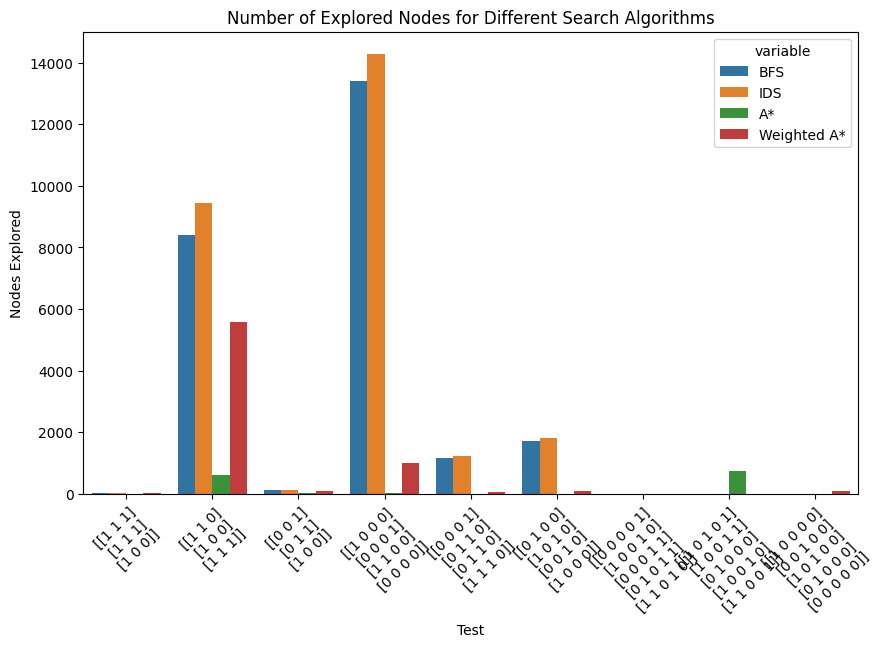

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming results is a list of tuples with SearchResult objects for each algorithm
# Extracting relevant data for plotting

tests = []
bfs_nodes = []
ids_nodes = []
astar_nodes = []
weighted_astar_nodes = []

for result in results:
    tests.append(str(result[0]))  # Test description
    bfs_nodes.append(result[1].nodes_visited)  # BFS nodes visited
    ids_nodes.append(result[2].nodes_visited)  # IDS nodes visited
    astar_nodes.append(result[3].nodes_visited)  # A* nodes visited
    
    # Weighted A* (assuming multiple heuristics and weights)
    weighted_astar_nodes.append(result[4].nodes_visited)  # Weighted A* (example)

# Create a DataFrame for easier plotting
import pandas as pd
data = {
    'Test': tests,
    'BFS': bfs_nodes,
    'IDS': ids_nodes,
    'A*': astar_nodes,
    'Weighted A*': weighted_astar_nodes
}
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Test', y='value', hue='variable', data=pd.melt(df, ['Test']))
plt.title('Number of Explored Nodes for Different Search Algorithms')
plt.ylabel('Nodes Explored')
plt.xticks(rotation=45)
plt.show()


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming results is a list of tuples with SearchResult objects for each algorithm
# Extracting relevant data for plotting

tests = []
bfs_time = []
ids_time = []
astar_time = []
weighted_astar_time = []

for result in results:
    tests.append(str(result[0]))  # Test description
    bfs_time.append(result[1].time_taken)  # BFS time taken
    ids_time.append(result[2].time_taken)  # IDS time taken
    astar_time.append(result[3].time_taken)  # A* time taken

    # Assuming one weighted heuristic with multiple weights
    weighted_astar_time.append(result[4].time_taken)  # Weighted A* (example)

# Create a DataFrame for easier plotting
data = {
    'Test': tests,
    'BFS': bfs_time,
    'IDS': ids_time,
    'A*': astar_time,
    'Weighted A*': weighted_astar_time
}
df = pd.DataFrame(data)

# Plotting the time comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Test', y='value', hue='variable', data=pd.melt(df, ['Test']))
plt.title('Time Taken by Different Search Algorithms')
plt.ylabel('Time (seconds)')
plt.xlabel('Test Case')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


NameError: name 'results' is not defined